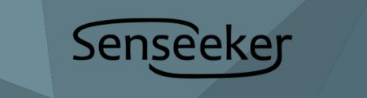
## Function DROIC Calculator

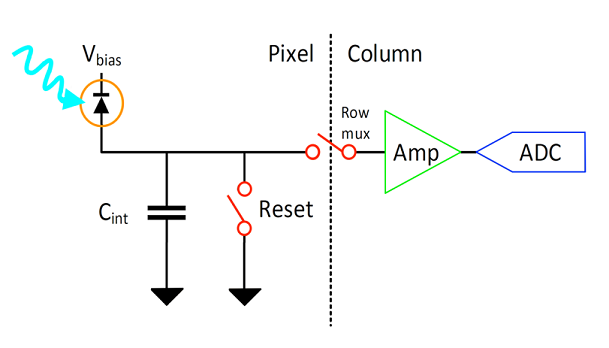

In [1]:
#DROIC - ROIC performance calculator version 20     18-Oct-2022
#%matplotlib widget
#%matplotlib inline
from ipywidgets import *
#import ipywidgets as widgets
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt


## Constants and parameters

# Constants
q = 1.602e-19 # [C], Elementary charge
kB = 1.38e-23 # [J/K], Boltzmann's constant

# Calculation parameters
t = np.logspace(-9,-1,1000) # [s], Integration time vector
t1 = np.ones(t.shape) # Ones vector of size(t)


## "Set Parameters" section heading
SetParamHdg = widgets.HTML(value = "<p style='font-size:16pt'><b>Set Parameters</b></p>")
display(SetParamHdg)
#print("Set Paramters:")

skip = False

## Plot function
def plotfun(Isig,Idk,Vmax,Vn_Amp_Ampin,T,Res_ADC,CifF,Tint):  #Rdata,Npix  skip for easy version

    if Isig <= 0:
        skip = True
    elif Idk <=0:
        skip = True
    elif Vmax <=0:
        skip = True
    elif Vn_Amp_Ampin <=0:
        skip = True
    elif CifF <=0:
        skip = True
    else:
        skip = False
        
    if skip == True:
        print ('Invalid Inputs')
    else: 
        #slider input data that was skipped for easy version (set as fixed)
        Rdata= 5000
        Npix = 1
        #T=80  #used only if the Temp input is disabled.

        ## Parse parameters
        Ci = CifF * 1e-15 # [F], Integration capacitance (get value in F)
        Vn_Amp_Ampin = Vn_Amp_Ampin * t1 # [Vrms], Amplifier noise referred to amplifier input (multiply by ones vector)

        ## Compute noise and SNR

        # Total pixel current
        Itot = Isig + Idk # [A]

        # ADC conversion gain
        G_ADC = 2**Res_ADC / Vmax # [DU/V], ADC gain

        # Quantization noise
        Dn_quant_out = 1/np.sqrt(12) * t1 # [DUrms]

        # Integrated pixel voltage
        Vtot_pix = np.minimum(Itot * t /Ci,Vmax) # [V], Total
        Vsig_pix = Vtot_pix * Isig/Itot # [V], Signal only

        # Pixel noise sources
        Vn_shot_pix = np.sqrt(q * Vtot_pix /Ci) * t1 # [Vrms], Shot noise
        Vn_kTC_pix = np.sqrt(kB * T /Ci) * t1 # [Vrms], kTC (reset) noise

        # Propagate signal to output
        Dsig_out = Vsig_pix * G_ADC # [DU]

        # Propagate all noise sources to output
        Dn_shot_out = Vn_shot_pix * G_ADC # [DUrms]
        Dn_kTC_out = Vn_kTC_pix * G_ADC # [DUrms]
        Dn_Amp_out = Vn_Amp_Ampin * G_ADC # [DUrms]

        # Sum all noises at output
        Dntot_out = np.sqrt(Dn_shot_out**2 + Dn_kTC_out**2 + Dn_Amp_out**2 + Dn_quant_out**2) # [DUrms]

        # Compute SNR
        SNR = 20*np.log10(Dsig_out/Dntot_out) # [dB]


        ## Compute other results

        # Well capacity
        Nwell = Ci * Vmax / q # [#e-]

        # Read noise in electrons
        Nnread = Dntot_out[0] / G_ADC * Ci / q # [#e-]

        # Max SNR
        SNRmax = np.amax(SNR) # [dB]

        # Dynamic range
        DR = 20*np.log10(np.amax(Dsig_out)/Dntot_out[0]) # [dB]

        # Saturation time
        tSat = Nwell * q / Itot # [s]

        # Read time
        tRead = Npix * Res_ADC / Rdata # [s]

        # Max frame rate (no integration)
        FRmax0 = 1/tRead # [fps]

        # Max frame rate (full well, IWR)
        FRmax_MW_IWR = 1/np.maximum(tSat,tRead) # [fps]

        # Max frame rate (full well, ITR)
        FRmax_MW_ITR = 1/(tSat+tRead) # [fps]

        
        i=0
        index = 77777
        for i in range (0, 1000):
            if t[i] < Tint:
                i+=1
            else:
                index=i
                break

        ## Define limiting noise string

        # Determine limiting noise
        DnmaxIndex = np.argmax((Dn_kTC_out[0],Dn_Amp_out[0],Dn_quant_out[0],Dn_shot_out[i]))

        # Define string
        if DnmaxIndex == 0:
            LimitingNoise = 'reset'
        elif DnmaxIndex == 1:
            LimitingNoise = 'amplifier'
        elif DnmaxIndex == 2:
            LimitingNoise = 'quantization' 
        elif DnmaxIndex == 3:
            LimitingNoise = 'SHOT'

        wf = str(round(100*(Tint * Isig)/(q*Nwell),2))
            
        ## "Calculated Results" section heading and text results
        CalcResults = widgets.HTML(value = "<br><p style='font-size:16pt'><b>Calculated Results:</b></p>"
            "<b>Well capacity</b>: " + str(round(Nwell/1e6,2)) + " Me-  <b> Well fill: </b>" + wf + " %   <b>      Read noise</b>: " + str(int(Nnread)) + " e-" + "&emsp;  Limited by <b><i>" + LimitingNoise + "</i></b> noise<br>"
            "<b>Max SNR = </b> " + str(round(SNRmax,1)) +   "dB <b> Dynamic range = </b> " + str(round(DR,1)) + " dB <b>  SNR = </b> " + str(round(SNR[index],2)) + 'dB <b> at Tint = </b>' + str(round(Tint/1e-06,2)) + 'usec <r>:'
            #"<b>Max frame rate (no integration)</b>: " + str(round(FRmax0,1)) + " fps<br>"
            #"<b>Max frame rate (full well, IWR)</b>: " + str(round(FRmax_MW_IWR,1)) + " fps<br>"
            #"<b>Max frame rate (full well, ITR)</b>: " + str(round(FRmax_MW_ITR,1)) + " fps<br>"
        )

        
        display(CalcResults)    

        ## Plot all noise sources (with sum) and signal, at output and referred to input
        plt.style.use('classic')
        fig = plt.figure(figsize=(13,7));
        ax1 = fig.add_subplot(1,2,2)
        plt.xlim((1e-07,0.1))
        ax1.loglog(t,Dn_shot_out,'-r',label='Shot noise',linewidth=3)
        ax1.loglog(t,Dn_kTC_out,'-m',label='Reset noise',linewidth=1.25)
        ax1.loglog(t,Dn_Amp_out,'-c',label='Amplifier noise',linewidth=1.25)
        ax1.loglog(t,Dn_quant_out,'-b',label='Quantization noise',linewidth=1.25)
        ax1.loglog(t,Dntot_out,'-k',label='TOTAL noise',linewidth=4)
        ax1.loglog(t,Dsig_out,'-g',label='Signal',linewidth=4)
        duliney = [0.0001, 1, 100000]
        dulinex = [Tint, Tint, Tint]
        ax1.loglog(dulinex, duliney,'--k')
        if Tint < 1e-3:
            plt.text(Tint*1.5, 2e-4, "Tint = " + str(round(Tint/1e-3,2)) + 'msec',color='grey',fontsize=15)
        else:
            plt.text(Tint*1e-2, 2e-4, "Tint = " + str(round(Tint/1e-3,2)) + 'msec',color='grey',fontsize=15)
        ax1.grid()
        ax1.set_xlabel('Integration time [s]')
        ax1.set_ylabel('Output noise [DU]')
        ax1.legend(loc='upper left',fontsize='medium')
        #plt.title('Noise budget')

        # Integration time [s] to signal [#e-] conversion function for secondary x-axis
        def t2sig(x):
            return x * Isig / q

        # Signal [#e-] to integration time [s] conversion function for secondary x-axis
        def sig2t(x):
            return x * q / Isig

        # Output [DU] to input [#e-] conversion function for secondary y-axis
        def out2in(x):
            return x / G_ADC * Ci / q

        # Input [#e-] to output [DU] conversion function for secondary y-axis
        def in2out(x):
            return x * q / Ci * G_ADC

        # Secondary axes
        secaxx = ax1.secondary_xaxis('top', functions=(t2sig, sig2t)) # x-axis in units of #e-
        secaxy = ax1.secondary_yaxis('right', functions=(out2in, in2out)) # y-axis in units of #e-
        secaxx.set_xlabel('Signal [#e-]')
        secaxy.set_ylabel('Input-referred noise [#e-]')

        #plt.figure(2);
        plt.style.use('dark_background')
        ax2=fig.add_subplot(1,2,1)
        ax2.semilogx(t,SNR,color='orange',linewidth=4)
        vlinex = np.repeat(Tint,3)
        vliney = [0, 50, 100] 
        hlinex = [1e-9, 1e-5, 1e-1]
        hliney = np.repeat(SNR[index],3)
        if SNR[index] >=0:
            plt.plot (vlinex,vliney,'--',color='grey',linewidth=2)
            plt.plot (hlinex,hliney,'--',color='grey',linewidth=2)
            plt.text(1.25e-08, SNR[index]+1, "SNR = " + str(round(SNR[index],2)) + 'db',color='orange',fontsize=15)
        if Tint < 1e-3:
            plt.text(Tint*1.6, 2, "Tint = " + str(round(Tint/1e-3,2)) + 'msec',color='orange',fontsize=15)
        else:
            plt.text(Tint*1e-2, 2, "Tint = " + str(round(Tint/1e-3,2)) + 'msec',color='orange',fontsize=15)

        plt.ylim((0,DR))
        plt.xlim((1e-07,0.1))
        ax2.grid()
        ax2.set_xlabel('Integration time [s]')
        ax2.set_ylabel('SNR [dB]')
        plt.title('Signal-to-noise ratio')

    
    
# Description width style
style = {'description_width': 'initial'}

# Main interact() call
interact(plotfun,
    Isig = widgets.FloatText(value=2.0e-10, step=1e-11,description=r'$I_{\rm sig}$ (A)'), # [A], Input signal current
    Idk = widgets.FloatText(value=2.7e-12, step=1e-15,description=r'$I_{\rm dark}$ (A)'), # [A], Dark current
    Vn_Amp_Ampin = widgets.FloatText(value=1e-4, step=1e-5,description=r'$V^n_{\rm amp}$ (V$_{\rm rms}$)'), # [Vrms], Amplifier noise referred to amplifier input
    #Rdata = widgets.FloatText(value=5000, description='Data rate (Mbps)', style=style), # [Mbps], DROIC total data transmission rate
    #Npix = widgets.FloatText(value=1, description=r'Array size (MPix)', style=style), # [Mpix], Total array size (number of pixels)
    Vmax = widgets.FloatText(value=2.0, min=0.001, max=10, step=0.1, description=r'$V_{\rm max}$ (V)'), # [V], Maximum integration node voltage
    T = widgets.FloatText(value=120, min=10, max=400, step=1, description=r'$T$ (K)'), # [K], Operating temperature
    Res_ADC = widgets.IntText(value=14, min=1, max=30, step=1,description=r'$ADC$ # bits:'), # [# bits], ADC resolution
    CifF = widgets.FloatSlider(value=800, min=100, max=5000, description='C_int (fF)',style=style,layout=Layout(width='530px'),readout_format='.4e',continuous_update=False), # [fF], Integration capacitance   
    Tint = widgets.FloatLogSlider(value=3.0e-05, min=-7, max=-1, description='Integration time (sec)', style=style, layout=Layout(width='530px'),readout_format='.4e',continuous_update=False) 
    );

HTML(value="<p style='font-size:16pt'><b>Set Parameters</b></p>")

interactive(children=(FloatText(value=1e-09, description='$I_{\\rm sig}$ (A)'), FloatText(value=1e-15, descrip…

Code by: Zach Korth, Senseeker Engineering